In [1]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from tensorboardX import SummaryWriter
import numpy as np

# 定义自己想用的网络
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # 2维卷积 参数： 输入通道数， 输出通道数， 卷积核大小， 步长， 边界填0数
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        # relu 激活函数
        self.relu1 = nn.ReLU(inplace=True)
        # 最大池化 参数：池化核大小， 步长
        self.max_pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.max_pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten1 = nn.Flatten(start_dim=1, end_dim=-1)
        # 全连接层 参数： 输入特征长度， 输出特征长度
        self.linear1 = torch.nn.Linear(in_features=16*7*7, out_features=120)
        self.relu3 = nn.ReLU(inplace=True)
        self.linear2 = torch.nn.Linear(in_features=120, out_features=84)
        self.relu4 = nn.ReLU(inplace=True)
        self.linear3 = torch.nn.Linear(in_features=84, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.max_pool1(x)
        x = self.relu2(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        # 将数据的shape从 B C H W -> B C HW  
        x = self.flatten1(x)
        x = self.linear1(x)
        x = self.relu3(x)
        x = self.linear2(x)
        x = self.relu4(x)
        y = self.linear3(x)
        return y

# 设置超参数
num_epochs = 2
learning_rate = 0.001

# 学习率衰减系数
weight_decay = 5e-4
# 训练集的batchsize
batch_size_train = 64
# 测试集的batchsize
batch_size_test = 64

# 构造训练数据集trian_loader(dataset->dataloader)
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)
# 构造测试数据集test_loader(dataset->dataloader)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

model = AlexNet()
print(model)

c:\Users\Administrator\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Administrator\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\Administrator\AppData\Local\Programs\Python\Python38\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


AlexNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU(inplace=True)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU(inplace=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=120, bias=True)
  (relu3): ReLU(inplace=True)
  (linear2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU(inplace=True)
  (linear3): Linear(in_features=84, out_features=10, bias=True)
)


In [2]:

losses = [] #用于保存训练过程中的 loss 值
acces = []

def train(model, total_epochs, train_dataloader, test_dataloader, optim, save_dir, writer):
    model.train()
    best_acc = 0.0
    step_train = 0
    firststep = 0
    for epoch in range(num_epochs):
        dataloader = tqdm(train_dataloader)
        dataloader.set_description('epoch: {}/{}'.format(epoch + 1, num_epochs))
        for i, data in enumerate(dataloader):
            # 前向传播
            x_data = data[0]
            y_data = data[1]
            outs = model(x_data)
            acc = 0
            loss = F.cross_entropy(outs, y_data)
            # 计算每个batch的loss平均值
            avg_loss = torch.mean(loss)
            
            # 获取预测的标签
            preds = torch.argmax(outs, dim = 1)
            # 计算每个batchsize的acc
            acc = torch.sum(preds == y_data)/preds.shape[0]

            # 打印训练过程
            if i % 100 ==0:
                step_train += 1
                # scalar组件
                writer.add_scalar(tag="train/loss", scalar_value=avg_loss, global_step=step_train)
                writer.add_scalar(tag="train/acc", scalar_value=acc, global_step=step_train)

                losses.append(avg_loss.detach().numpy())
                acces.append(acc.detach().numpy())
                # print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch_id, batch_id, loss.detach().numpy(), acc.detach().numpy()))

            # 反向传播和优化
            avg_loss.backward()
            optim.step()

            writer.add_scalar(tag="train/loss", scalar_value=avg_loss, global_step=step_train)
            
            # losses.append(model .detach().numpy())
            if firststep==0:
                firststep=1
                tip = 0
                for parms in model.parameters():
                    tip += 1
                    if tip ==1:
                        filter1 = parms.grad
                    if tip ==3: #只有conv层可以可视化，maxpooling层和relu层不能可视化
                        filter3 = parms.grad
                

                torch.save({"conv1":filter1, "conv2":filter3},"./grad")

            optim.zero_grad()

            dataloader.set_postfix(loss='{:.4f}'.format(loss.detach().numpy()), acc='{:.4f}'.format(acc.detach().numpy()))
                
        # 保存每轮epoch的模型
        save_model_dir = save_dir +"/model{}".format(epoch+1)+".pth"
        # 保存的模型
        torch.save(model.state_dict(),save_model_dir )
        print("model is saved in: "+str(save_model_dir))

        # eval方法
        val_acc = eval(model, test_dataloader, epoch, writer)
        if val_acc > best_acc:
            # 保存最佳模型
            save_model_dir = save_dir +"/best_model"+".pth"
            # 保存模型
            torch.save(model.state_dict(), save_model_dir )
            print("best_model is saved in: "+str(save_model_dir))
            best_acc = val_acc
            print("best_acc: "+str(best_acc.detach().numpy()))

            

In [3]:
def eval(model, test_dataloader, epoch_id, writer):
    val_sums = []
    # 将模型设置为验证模式，这样就不会计算梯度
    model.eval()
    dataloader = tqdm(test_dataloader)
    dataloader.set_description('val')
    # 获取dataloader的数据
    for batch_id, data in enumerate(dataloader):
        # 获取第一个数据，即图像的tensor
        x_data = data[0]
        # 获取第二个数据，即图像的类别tensor
        y_data = data[1]
        # 将图像放入模型前向计算，并获取预测结果
        outs = model(x_data)
        
        # 获取预测结果的分类类别
        preds = torch.argmax(outs, dim = 1)
        # 计算预测准确的数量
        sums = torch.sum(preds == y_data)
        # 把每个batch的预测准确数量加入到数组中，便于后续计算acc
        val_sums.append(sums)
        
    # 添加验证集的图像
    # 将标签转为numpy类型
    tag = preds[epoch_id].detach().numpy()
    # print('tag:', tag)
    # 获取第epoch_id的图像tensor
    img = x_data[epoch_id,:,:,:]
    # 将tensor从 C H W -> H W C
    img = img.permute(1,2,0)
    writer.add_image(tag="数字: "+str(tag), global_step=epoch_id, img_tensor=img[:,:,0], dataformats='HW')

    # 添加验证集的acc变化
    # 计算acc，数组里预测准确数量总和除以数据总量
    val_acc = sum(val_sums)/len(test_dataloader.dataset)
    # 将特定图像加入到tensorboard
    writer.add_scalar(tag="val/acc", global_step=epoch_id, scalar_value=val_acc)
    print("batch_id: {}, acc is: {:.4f}".format(batch_id,  val_acc.detach().numpy()))
    return val_acc

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
save_dir = './ckp/MNIST/Adam1'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists('./log/MNIST/'):
    os.makedirs('./log/MNIST/')
writer = SummaryWriter(logdir= 'log/MNIST/Adam')

In [5]:
train(model, num_epochs, train_loader, test_loader, optimizer, save_dir, writer)
# 这部分可以多次运行，提高acc

epoch: 1/2:   7%|▋         | 61/938 [00:01<00:18, 47.80it/s, acc=0.9219, loss=0.3492]


KeyboardInterrupt: 

tag: 1


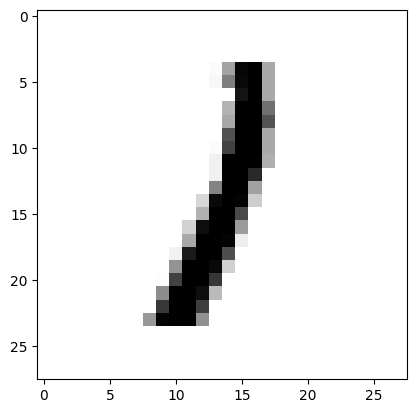

torch.Size([28, 28, 1])


In [4]:
# 加载模型
model_dict = torch.load('./ckp/MNIST/Adam1/best_model.pth')
model.load_state_dict(model_dict)
# 模型设置为测试模式
model.eval() 
test_sums = []

for batch_id, data in enumerate(test_loader):
    # 获取数据
    # print(data[0].shape)
    x_data = data[0]
    y_data = data[1]
    # 模型的前向计算
    outs = model(x_data)
    # print(outs.shape)
    # 获取预测结果
    preds = torch.argmax(outs, dim = 1)
    sums = torch.sum(preds == y_data)
    test_sums.append(sums)
        
# 添加验证集的图像
# 和前面eval一样
tag = preds[0].detach().numpy()
print('tag:', tag)
# 由于图像是B C H W，只要batch的第一个
img = x_data[0,:,:,:]
# 将C H W-> H  W  C
img = img.permute(1,2,0)
# 图像显示
plt.figure()
plt.imshow(img[:,:,0], cmap=plt.cm.binary)  #图片大小为 [32,32]
plt.show()
print(img.shape)

In [5]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the 10000 test images: {100 * correct / total} %')

# 保存模型
torch.save(model.state_dict(), 'model.pth')

Accuracy of the model on the 10000 test images: 98.74 %


In [39]:
# FGSM和PGD攻击
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Attack():
    def fgsm(self,image,label,epsilon):
        image.requires_grad = True
        output = model(image)
        loss = loss_fn(output, label)
        loss.backward()
        image_adv = image + epsilon * image.grad.sign()
        image_adv = torch.clamp(image_adv, 0, 1)

        return image_adv

    def PGD(self,image,label,epsilon):

        images = image.clone().detach().to(device)
        labels = label.clone().detach().to(device)

        adv_images = images.clone().detach()

        adv_images = adv_images + torch.empty_like(adv_images).uniform_(-epsilon, epsilon)
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(10): #迭代进行攻击
            adv_images.requires_grad = True
            outputs = model(adv_images)

            cost = loss_fn(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            adv_images = adv_images.detach() + epsilon*grad.sign()
            delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

#FGSM算法
model.eval()
correct = 0 #攻击后仍然分类正确的样本数量
total = 0 #测试使用的样本总量
init_correct = 0 #攻击前模型能正确分类的样本数量
epsilon = 0.5 #这里修改扰动阈值
atk = Attack()
for image, label in tqdm(test_loader):
    init_outputs = model(image)
    _, init_predicted = torch.max(init_outputs.data, 1)
    image = image.to(device)
    label = label.to(device)
    image_adv = atk.fgsm(image,label,epsilon) #在这里选择使用fgsm还是pgd算法
    # image_adv = atk.PGD(image,label,epsilon)
    outputs = model(image_adv)
    _, predicted = torch.max(outputs.data, 1)
    total += label.size(0)
    init_correct_squ = init_predicted == label
    correct_squ = predicted == label
    correct += (correct_squ & init_correct_squ).sum().item()
    init_correct += init_correct_squ.sum().item()

print("epsilon: "+str(epsilon))
print(f'Accuracy of the model now: {100 * correct / total} %')
print(f'Accuracy of the attack: {100 * (init_correct-correct) / init_correct} %')
print(correct)
print(total)
print(init_correct)

100%|██████████| 157/157 [00:03<00:00, 40.76it/s]

epsilon: 0.5
Accuracy of the model now: 84.64 %
Accuracy of the attack: 14.279927081223414 %
8464
10000
9874


In [38]:
# PGD算法
model.eval()
correct = 0
total = 0
init_correct = 0
epsilon = 0.5
atk = Attack()
for image, label in tqdm(test_loader):
    init_outputs = model(image)
    _, init_predicted = torch.max(init_outputs.data, 1)
    image = image.to(device)
    label = label.to(device)
    image_adv = atk.PGD(image,label,epsilon) #在这里选择使用fgsm还是pgd算法
    # image_adv = atk.fgsm(image,label,epsilon)
    outputs = model(image_adv)
    _, predicted = torch.max(outputs.data, 1)
    total += label.size(0)
    init_correct_squ = init_predicted == label
    correct_squ = predicted == label
    correct += (correct_squ & init_correct_squ).sum().item()
    init_correct += init_correct_squ.sum().item()

print("epsilon: "+str(epsilon))
print(f'Accuracy of the model now: {100 * correct / total} %')
print(f'Accuracy of the attack: {100 * (init_correct-correct) / init_correct} %')
print(correct)
print(total)
print(init_correct)

100%|██████████| 157/157 [00:12<00:00, 12.49it/s]

epsilon: 0.5
Accuracy of the model now: 75.51 %
Accuracy of the attack: 23.52643305651205 %
7551
10000
9874


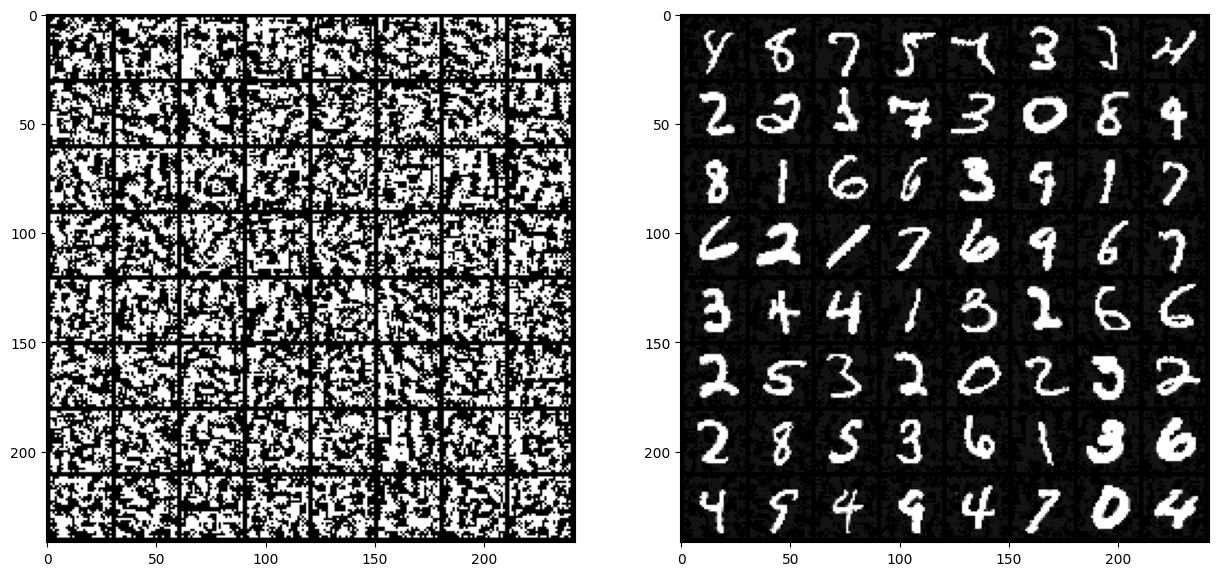

In [8]:
# FGSM可视化
for image, label in test_loader:
    image.requires_grad = True
    output = model(image)
    loss = loss_fn(output, label)
    loss.backward()
    plt.figure(figsize=(15, 8))

    plt.subplot(121)
    image_grid = torchvision.utils.make_grid(torch.clamp(image.grad.sign(), 0, 1))
    plt.imshow(np.transpose(image_grid.cpu().numpy(), (1, 2, 0)))
    # 可视化对抗干扰
        
    image_adv = image + epsilon * image.grad.sign()
    image_adv = torch.clamp(image_adv, 0, 1)

    plt.subplot(122)
    image_grid = torchvision.utils.make_grid(image_adv)
    plt.imshow(np.transpose(image_grid.cpu().numpy(), (1, 2, 0)))
    # 可视化对抗样本

    break

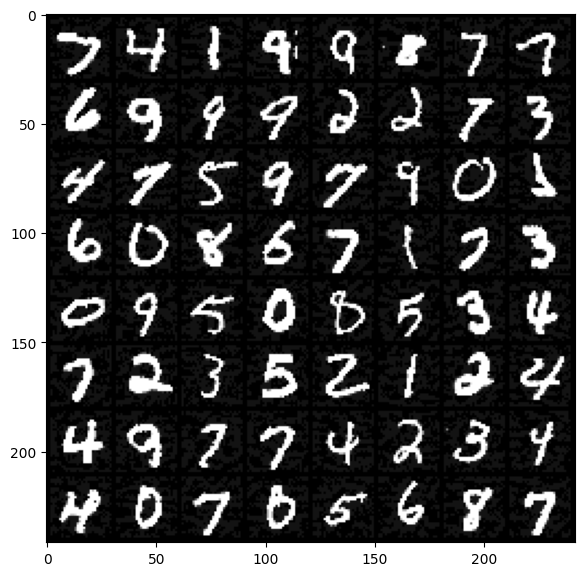

In [9]:
# PGD可视化
for image, label in test_loader:

    images = image.clone().detach().to(device)
    labels = label.clone().detach().to(device)

    adv_images = images.clone().detach()

    adv_images = adv_images + torch.empty_like(adv_images).uniform_(-epsilon, epsilon)
    adv_images = torch.clamp(adv_images, min=0, max=1).detach()

    for _ in range(10):
        adv_images.requires_grad = True
        outputs = model(adv_images)

        cost = loss_fn(outputs, labels)

        # Update adversarial images
        grad = torch.autograd.grad(cost, adv_images,
                                    retain_graph=False, create_graph=False)[0]

        adv_images = adv_images.detach() + epsilon*grad.sign()
        delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
        adv_images = torch.clamp(images + delta, min=0, max=1).detach()
    plt.figure(figsize=(15, 8))

    plt.subplot(122)
    image_grid = torchvision.utils.make_grid(adv_images)
    plt.imshow(np.transpose(image_grid.cpu().numpy(), (1, 2, 0)))
    # 可视化对抗样本

    break

In [44]:
# deepfool攻击
import copy
from torch.autograd import Variable

def deepfool(image, net, num_classes=10, overshoot=0.02, max_iter=300): #
  f_image = net.forward(Variable(image[None, :, :, :], requires_grad=True)).data.cpu().numpy().flatten()
  I = (np.array(f_image)).flatten().argsort()[::-1]

  I = I[0:num_classes]
  label = I[0]

  input_shape = image.cpu().numpy().shape
  pert_image = copy.deepcopy(image)
  w = np.zeros(input_shape)
  r_tot = np.zeros(input_shape)

  loop_i = 0 # 迭代次数

  x = Variable(pert_image[None, :], requires_grad=True)
  fs = net.forward(x)
  fs_list = [fs[0,I[k]] for k in range(num_classes)]
  k_i = label

  while k_i == label and loop_i < max_iter: #
    pert = np.inf
    fs[0, I[0]].backward(retain_graph=True)
    grad_orig = x.grad.data.cpu().numpy().copy()

    for k in range(1, num_classes):
      if x.grad is not None:
        x.grad.zero_()

      fs[0, I[k]].backward(retain_graph=True)
      cur_grad = x.grad.data.cpu().numpy().copy()

      # set new w_k and new f_k
      w_k = cur_grad - grad_orig
      f_k = (fs[0, I[k]] - fs[0, I[0]]).data.cpu().numpy()

      pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

      # determine which w_k to use
      if pert_k < pert:
          pert = pert_k
          w = w_k

      # compute r_i and r_tot
      # Added 1e-4 for numerical stability
    r_i =  (pert+1e-4) * w / np.linalg.norm(w)
    r_tot = np.float32(r_tot + r_i)
    pert_num = np.linalg.norm((1+overshoot)*torch.from_numpy(r_tot).flatten())

    pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

    x = Variable(pert_image, requires_grad=True)
    fs = net.forward(x)
    k_i = np.argmax(fs.data.cpu().numpy().flatten())

    loop_i += 1

  r_tot = (1+overshoot)*r_tot
  return r_tot, loop_i, label, k_i, pert_image

# 生成对抗样本的个数
adver_nums = 1000
batch_size = 64
# 这几个变量主要用于之后的测试以及可视化
adver_example_by_FOOL = torch.zeros((batch_size,1,28,28)).to(device)
adver_target = torch.zeros(batch_size).to(device)
clean_example = torch.zeros((batch_size,1,28,28)).to(device)
clean_target = torch.zeros(batch_size).to(device)
# 从test_loader中选取1000个干净样本，使用deepfool来生成对抗样本
i = 0
for i ,(data,target) in enumerate(test_loader):
  if i >= adver_nums/batch_size :
    break
  if i == 0:
    clean_example = data
    #输出第一个样本的最小扰动和迭代次数作为例子
    r_rot,loop_i,label,k_i,pert_image = deepfool(data[0],model)
    print(loop_i)
    print(r_rot)
  else:
    clean_example = torch.cat((clean_example,data),dim = 0)

  cur_adver_example_by_FOOL = torch.zeros_like(data).to(device)

  for j in range(batch_size):
    r_rot,loop_i,label,k_i,pert_image = deepfool(data[j],model) #输出的r_rot就是最小扰动，loop_i就是最小迭代次数
    
    cur_adver_example_by_FOOL[j] = pert_image
  
  # 使用对抗样本攻击VGG模型
  pred = model(cur_adver_example_by_FOOL).max(1)[1]
  if i == 0:
    adver_example_by_FOOL = cur_adver_example_by_FOOL
    clean_target = target
    adver_target = pred
  else:
    adver_example_by_FOOL = torch.cat((adver_example_by_FOOL , cur_adver_example_by_FOOL), dim = 0)
    clean_target = torch.cat((clean_target,target),dim = 0)
    adver_target = torch.cat((adver_target,pred),dim = 0)
  i+=1

print (adver_example_by_FOOL.shape)
print (adver_target.shape)
print (clean_example.shape)
print (clean_target.shape)

3
[[[[ 8.28420930e-03 -4.75322157e-02 -1.03633858e-01  5.88561445e-02
     1.65220462e-02 -2.00194158e-02 -3.36447507e-02  8.45504701e-02
     8.39461088e-02  4.87248711e-02  1.14832446e-01 -6.84040040e-02
     4.46363129e-02  1.75432190e-02  4.88370992e-02  2.51610931e-02
     3.05585135e-02  1.16586477e-01  1.13956705e-01 -1.25152981e-02
     6.30187988e-03  5.50767817e-02  4.31413613e-02  6.60158470e-02
     2.06447504e-02  1.89468954e-02 -5.68935387e-02  9.74007591e-04]
   [-2.35620160e-02 -4.79695611e-02 -4.02953215e-02  4.33432870e-02
     3.56163681e-02  3.09005044e-02 -3.70233096e-02  7.34046176e-02
     4.25278991e-02  9.53596458e-02  2.99008265e-02  7.96982795e-02
    -1.16389885e-03 -2.22869981e-02  1.87778771e-02 -5.28462185e-03
     1.22927865e-02 -1.28807696e-02  7.41171986e-02 -4.97683473e-02
    -6.81970036e-03  2.84592751e-02  7.09689558e-02  2.90534161e-02
    -4.04237211e-02  3.26865986e-02  3.03722136e-02  6.22148588e-02]
   [-2.24491544e-02 -9.72852483e-02 -8.64736

In [45]:
import torch.utils.data as Data
def adver_attack(model,adver_example,target,name):
  adver_dataset = Data.TensorDataset(adver_example, target)
  loader = Data.DataLoader(
    dataset=adver_dataset,      # 数据，封装进Data.TensorDataset()类的数据
    batch_size=batch_size      # 每块的大小
    )
  correct_num = torch.tensor(0).to(device)
  for j,(data,target) in tqdm(enumerate(loader)):
    data = data.to(device)
    target = target.to(device)
    pred = model.forward(data).max(1)[1]
    num = torch.sum(pred==target)
    correct_num = correct_num + num
  print (correct_num)
  print(adver_nums)
  print ('\n{} correct rate is {}'.format(name,correct_num/adver_nums))

adver_attack(model,adver_example_by_FOOL,clean_target,'model')

16it [00:00, 286.49it/s]

tensor(11)
1000

model correct rate is 0.010999999940395355


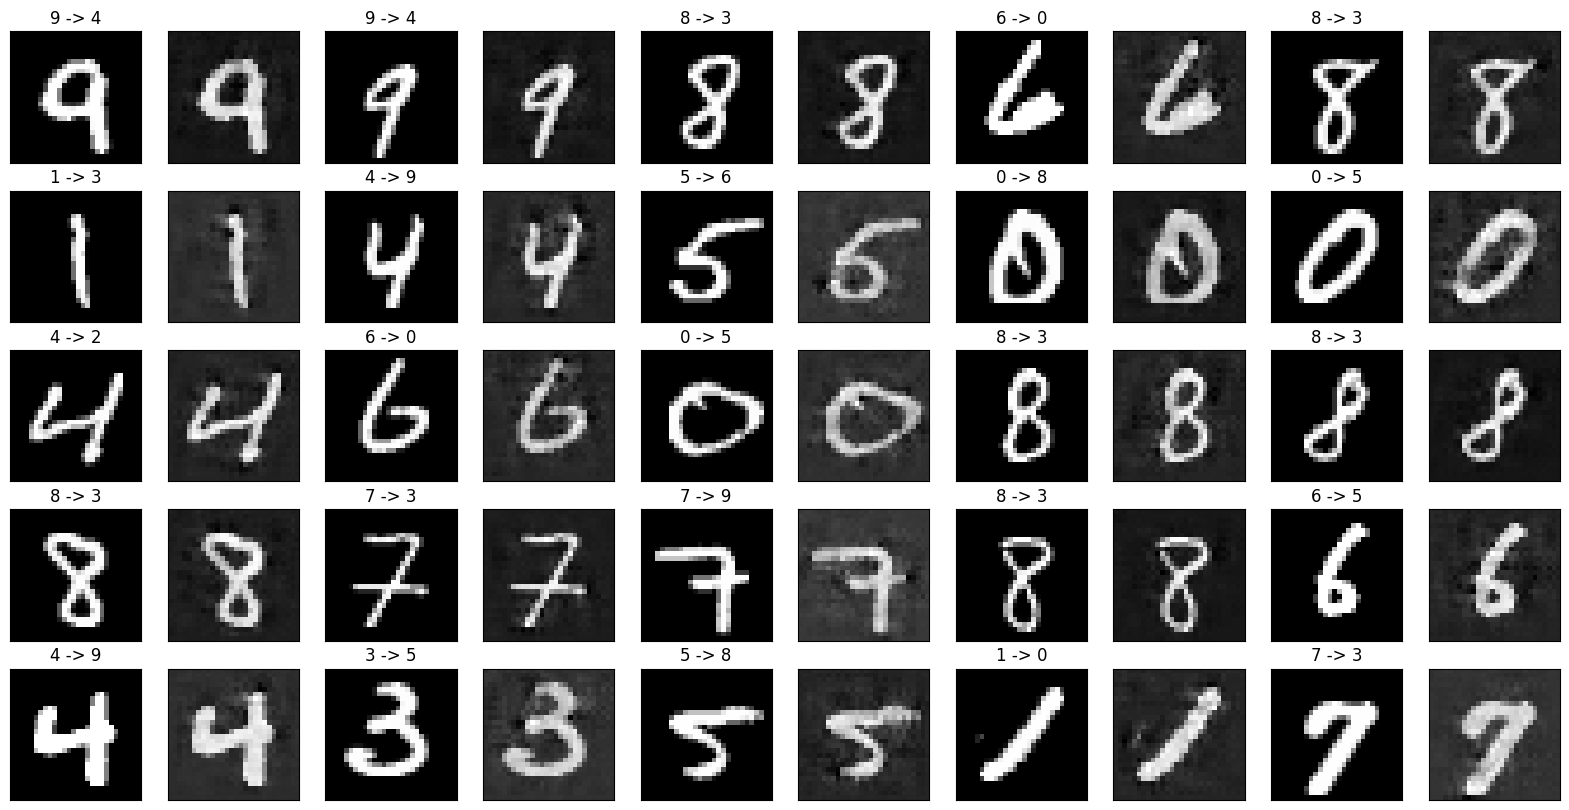

In [18]:
def plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target):
  n_cols = 5
  n_rows = 5
  cnt = 1
  cnt1 = 1
  plt.figure(figsize=(n_cols*4,n_rows*2))
  for i in range(n_cols):
    for j in range(n_rows):
      plt.subplot(n_cols,n_rows*2,cnt1)
      plt.xticks([])
      plt.yticks([])
      plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(clean_example[cnt].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      plt.subplot(n_cols,n_rows*2,cnt1+1)
      plt.xticks([])
      plt.yticks([])
      # plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(adver_example[cnt].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      cnt = cnt + 1
      cnt1 = cnt1 + 2
  plt.show()

plot_clean_and_adver(adver_example_by_FOOL,adver_target,clean_example,clean_target)

In [51]:
import warnings

class CW():
    def __init__(self, model, targeted=False, c=1e-4, kappa=0, steps=1000, lr=0.01):
        self.targeted = targeted
        self.c = c
        self.kappa = kappa
        self.steps = steps
        self.lr = lr
        self.model = model

    def forward(self, images, labels):
        images = images.to(device)
        labels = labels.to(device)

    # 这个函数用所有非目标标签的 logit 中最大值减去目标标签的 logit
    def f(self, x):
        outputs = self.model(x)
        one_hot_labels = torch.eye(outputs.size(1)).to(device)[self.labels]
        i, _ = torch.max((1 - one_hot_labels) * outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.bool())
        if self.targeted:
            return torch.clamp(i - j, min=-self.kappa)
        else:
            return torch.clamp(j - i, min=-self.kappa)

    def attack(self, images, labels):
        self.labels = labels
        self.forward(images, labels)
        w = torch.zeros_like(images).to(device)
        w.requires_grad = True
        optimizer = optim.Adam([w], lr=self.lr)

        prev = float('inf')
        for step in range(self.steps):
            a=1/2*(nn.Tanh()(w)+ 1)
            loss1 = torch.dist(a,(torch.tanh(w)*images+self.c),p=2) # nn.MSELoss(reduction='sum')(a,images)
            loss2 = torch.sum(self.c*self.f(a))
            # 编写loss1和loss2代码
            cost = loss1 + loss2
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
            if step % (self.steps // 10) == 0:
                if cost > prev:
                    warnings.warn("Early stopped cause the loss did not converge.")
                    return (1/2 * (nn.Tanh()(w) + 1)).detach()
                prev = cost

        return (1/2 * (nn.Tanh()(w) + 1)).detach()

model.eval()
correct = 0
total = 0
init_correct = 0
atk = CW(model)

adver_nums = 1000
batch_size = 64
i=0
# 这几个变量主要用于之后的测试以及可视化
adver_example_by_cw = torch.zeros((batch_size,1,28,28)).to(device)
adver_target = torch.zeros(batch_size).to(device)
clean_example = torch.zeros((batch_size,1,28,28)).to(device)
clean_target = torch.zeros(batch_size).to(device)
for image, label in tqdm(test_loader):
    if i >= adver_nums/batch_size :
        break
    if i == 0:
        clean_example = image
    else:
        clean_example = torch.cat((clean_example,image),dim = 0)
    cur_adver_example_by_cw = torch.zeros_like(image).to(device)

    init_outputs = model(image)
    _, init_predicted = torch.max(init_outputs.data, 1)
    image = image.to(device)
    label = label.to(device)
    image_adv = atk.attack(image, label)


    outputs = model(image_adv)
    # 使用对抗样本攻击VGG模型
    _, predicted = torch.max(outputs.data, 1)
    if i == 0:
        adver_example_by_cw = image_adv
        clean_target = label
        adver_target = predicted
    else:
        adver_example_by_cw = torch.cat((adver_example_by_cw , image_adv), dim = 0)
        clean_target = torch.cat((clean_target,init_predicted),dim = 0)
        adver_target = torch.cat((adver_target,predicted),dim = 0)
    total += label.size(0)
    init_correct_squ = init_predicted == label
    correct_squ = predicted == label
    correct += (correct_squ & init_correct_squ).sum().item()
    init_correct += init_correct_squ.sum().item()
    i+=1

print(f'Accuracy of the model now: {100 * correct / total} %')
print(f'Accuracy of the initial model: {100 * init_correct / total} %')
print(f'Accuracy of the attack: {100 * (init_correct-correct) / init_correct} %')
print(correct)
print(total)
print(init_correct)

 10%|█         | 16/157 [02:32<22:24,  9.53s/it]

Accuracy of the model now: 77.34375 %
Accuracy of the initial model: 98.6328125 %
Accuracy of the attack: 21.584158415841586 %
792
1024
1010


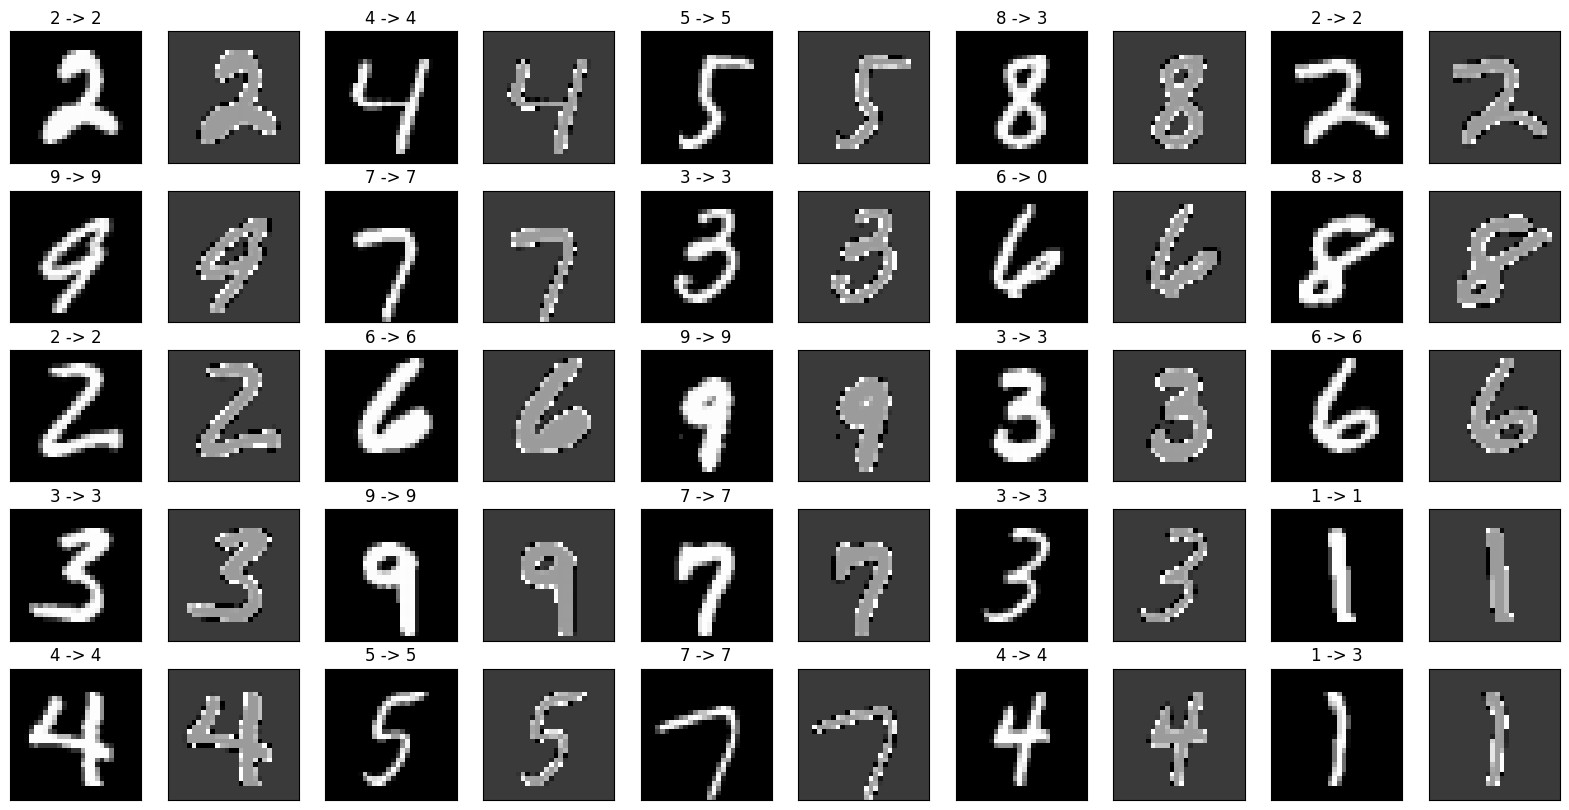

In [52]:
def plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target):
  n_cols = 5
  n_rows = 5
  cnt = 1
  cnt1 = 1
  plt.figure(figsize=(n_cols*4,n_rows*2))
  for i in range(n_cols):
    for j in range(n_rows):
      plt.subplot(n_cols,n_rows*2,cnt1)
      plt.xticks([])
      plt.yticks([])
      plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(clean_example[cnt].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      plt.subplot(n_cols,n_rows*2,cnt1+1)
      plt.xticks([])
      plt.yticks([])
      # plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(adver_example[cnt].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      cnt = cnt + 1
      cnt1 = cnt1 + 2
  plt.show()

plot_clean_and_adver(adver_example_by_cw,adver_target,clean_example,clean_target)